# Mental Health in Tech Industry

This project is analysis of mental health issues in tech industry using data from OSMI (Open Soure Mental Illness) survey. Below can be seen word cloud of mental health disorders with most frequent in this data having biggest fonts.

<img src="word_cloud.png" alt="Word Cloud">

# Introduction

My goal is to investigate what is situation about of mental health in workplace and ways can companies can improve mental health in tech workplace.

In this project I will be investigating following topics:
- What part of population has mental health disorders
- How much companies support mental health in workplace overall
- What are most common disorders
- Emplyees knowledge of resources available
- How open people are about mental health issues

## Data Set

To draw insights I will be using Open Source Mental Illness (OSMI) survey data from years 2014, 2016, 2017, 2018 and 2019 to draw insights. Download the dataset from [Kaggle.](https://www.kaggle.com/anth7310/mental-health-in-the-tech-industry)

It is important to highlight:
- data comes from surveys where anyone can take them thus it is non-probabilistic sample of population of tech workers. The validity of results depends on whether the non-probabilistic sample is representative.
- Anyone can take the survey, thus we need to check whether each unit belongs to population of interest which is tech workers.

Notice that I will preprocess data in appropriate way for this project. More details in following sections.

## Biases



- As this data is a survey about mental health, people with mental health issues might take it more frequently.
- This is non-probabilistic sample of population which we need to be aware before drawing conclusions about all target population.
- In data I found bias that in surveys after 2016 over 97% of respondents each following year answered that they have or had mental health disorder diagnosed. This might be due to the way data was collected and it is important to be aware of this
- There is triple times less survey respondants at the later years 2019, 2018 compared to surveys start in 2014 and 2016.
- The data in kaggle has 13 questions missing from the original OSMI dataset.
- There is 5 times more respondents from USA than any other country. And more than all respondents from other countries combined.
- There is 3 times more males than females in survey data. Notice that this might be bias that more males have taken this survey than females thus representing males more. It is important to say that our target population might have such proportions of genders working in this industry, thus showing inequality of genders proportion in target population rather than bias in survey.

## Domain knowledge


It is important to say that I am not a mental health expert and I am not qualified to give advice on mental health. For the purpose of this project I will be using data to draw insights and provide suggestions which are based on data. Nevertheless, how to apply these suggestions is up to mental health experts and companies.

## Libraries

In this analysis I am using kagglehub for ease of data downloading; pandas, numpy, matplotlib, seaborn for data manipulation and visualization;

In [31]:
import sqlite3
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from kagglehub import KaggleDatasetAdapter
from utils.data_processing import calculate_counts
from utils.logs import check_for_null_and_duplicates
from utils.plots import (
    analyze_null_values,
    plot_multiple_disorders_distribution,
    plot_question_grouped_by_answers,
    plot_question_grouped_by_years,
)
from utils.prevelance_rate_CI import analyze_disorder_prevalence, calculate_disorder_prevalence
from wordcloud import WordCloud

## Get data

To get data I used kagglehub to download data from Kaggle. There is a sql lite query to get data in appropriate format. Then I saved it to csv file to avoid downloading data every time I run the notebook.

In [32]:
raw_df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "anth7310/mental-health-in-the-tech-industry",
    "mental_health.sqlite",
    sql_query="""
        SELECT a.UserID, a.AnswerText, q.QuestionID, q.QuestionText, s.SurveyID, s.Description
        FROM Answer a
            LEFT JOIN Question q ON a.QuestionID = q.QuestionID
            LEFT JOIN Survey s ON a.SurveyID = s.SurveyID
        ORDER BY a.UserID, q.QuestionID, s.SurveyID
    """,
)

Path("data").mkdir(parents=True, exist_ok=True)
raw_df.to_csv("data/raw_mental_health.csv", index=False)

Notice that, after quirying the data, we dont need to qury the data again. So it is better to comment out the query and read the data from csv file below by uncommenting the line below. This will save time and resources on repeated queries.

```python
raw_df = pd.read_csv("data/raw_mental_health.csv")
```

Also, I saved processed data to csv file to avoid processing data every time I run the notebook. So it is better to comment out the processed data and read the data from csv file below by uncommenting the line below. This will save time and resources on repeated processing. If you are running the the notebook for the first time you have to create the csv file first by running Data Preprocessing section.

```python
processed_df = pd.read_csv("data/processed_mental_health.csv")
````

## Overview data

Lets take a look at the data

In [33]:
raw_df.head(5)

,UserID,AnswerText,questionid,questiontext,SurveyID,Description
0,1,37,1,What is your age?,2014,mental health survey for 2014
1,1,Female,2,What is your gender?,2014,mental health survey for 2014
2,1,United States,3,What country do you live in?,2014,mental health survey for 2014
3,1,Illinois,4,"If you live in the United States, which state ...",2014,mental health survey for 2014
4,1,-1,5,Are you self-employed?,2014,mental health survey for 2014


There are 236898 questions asked

In [34]:
raw_df.shape

(236898, 6)

With 4218 unique users answering questions. Important to note that there might be some of the same people as in each survey who come back every year to take the survey. Their user id's might be different each survey year

In [35]:
raw_df["UserID"].nunique()

4218

There are 105 unique questions asked

In [36]:
raw_df["questionid"].nunique()

105

In this dataset we have 5 samples with different number of questions asked and different number of users participated. This shows that we somehow need to uniform the questions or focus on some specific questions shared in all samples.

In [37]:
grouped_df = (
    raw_df.groupby(by="SurveyID")
    .agg(
        question_count=("questionid", "size"),
        unique_questions=("questionid", "nunique"),
        unique_users=("UserID", "nunique"),
    )
    .reset_index()
)
grouped_df

,SurveyID,question_count,unique_questions,unique_users
0,2014,32760,26,1260
1,2016,88238,60,1433
2,2017,57456,76,756
3,2018,31692,76,417
4,2019,26752,76,352


As we can see from the graph below there is triple times less unique respondents in later years 2018, 2019 than in starting survey years in 2014 and 2016

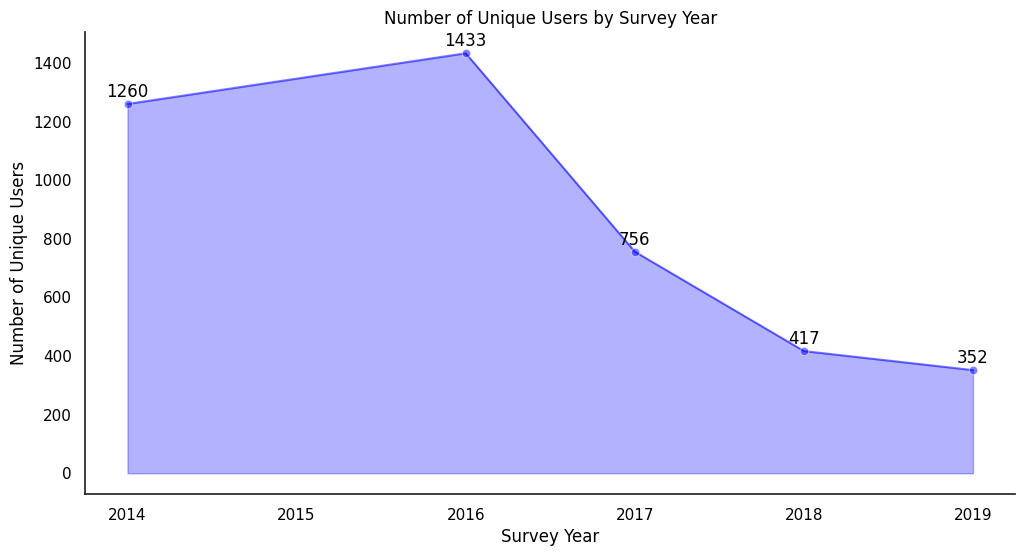

In [38]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=grouped_df, x="SurveyID", y="unique_users", marker="o", alpha=0.5, color="blue"
)
for x, y in zip(grouped_df["SurveyID"], grouped_df["unique_users"], strict=False):
    ax.annotate(f"{y}", (x, y), textcoords="offset points", xytext=(0, 5), ha="center")
plt.fill_between(grouped_df["SurveyID"], grouped_df["unique_users"], alpha=0.3, color="blue")
plt.title("Number of Unique Users by Survey Year")
plt.xlabel("Survey Year")
plt.ylabel("Number of Unique Users")
sns.despine()

In [39]:
conn = sqlite3.connect("data/database.sqlite")

Notice how there is no questions between question id 34 and 48. That is 13 questions in kaggle dataset from original survey data. This might contain some important information

In [40]:
pd.read_sql_query("SELECT * FROM Question WHERE rowid BETWEEN 33 AND 37", conn)

,questiontext,questionid
0,Do you currently have a mental health disorder?,33
1,Have you ever been diagnosed with a mental hea...,34
2,"If you have a mental health disorder, how ofte...",48
3,"If you have a mental health disorder, how ofte...",49
4,What country do you work in?,50


I will now query data about ages in the dataset

In [41]:
ages_df = pd.read_sql_query(
    """ SELECT q.questiontext, a.AnswerText, COUNT(a.AnswerText) as count
        FROM Question q
            LEFT JOIN Answer a ON q.questionID == a.questionID
        WHERE q.questionid == 1
            AND a.AnswerText NOT IN ("-1","-29", "0","8","5","99","323", "329", "3")
        GROUP BY a.AnswerText
        ORDER BY a.AnswerText ASC""",
    conn,
)

Below you can see the distribution of survey participants. Most of respondants are somewhere from 23 till 40 years old.

Text(0.5, 0, 'Different Ages')

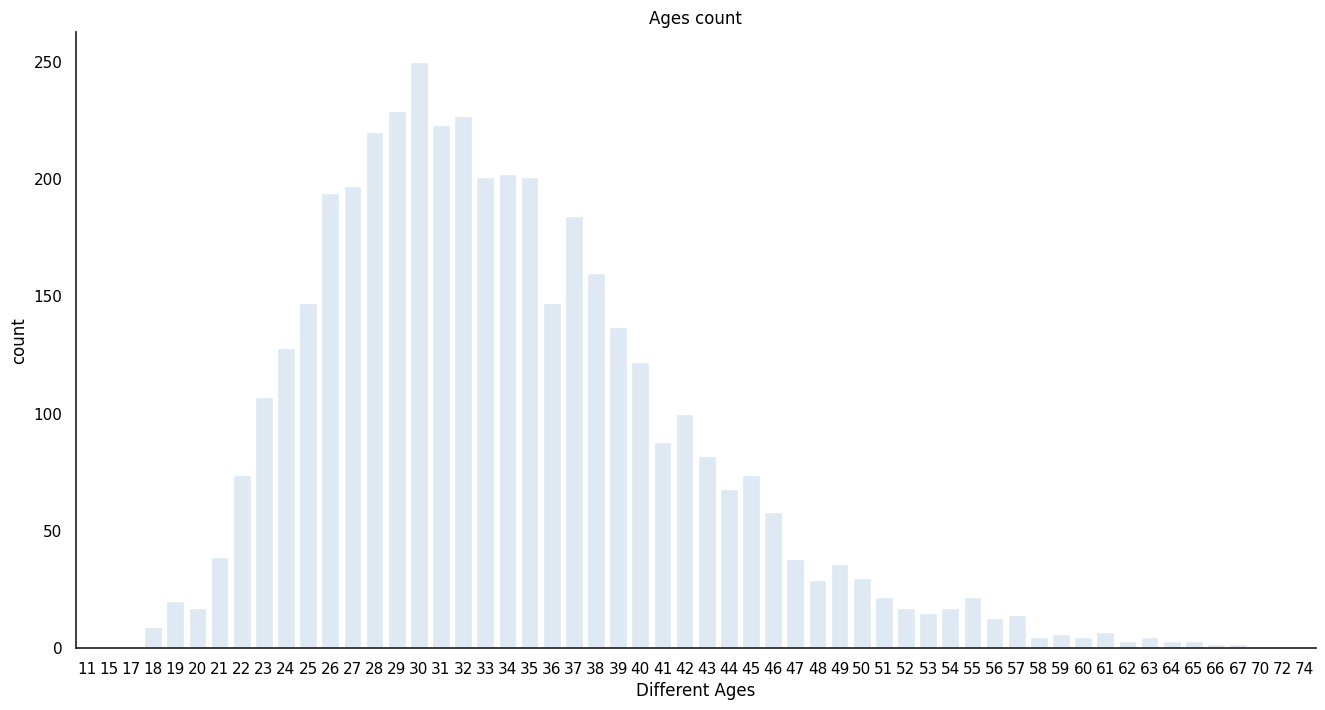

In [42]:
plt.figure(figsize=(16, 8))
ax = sns.barplot(ages_df, x="AnswerText", y="count")
sns.despine()
plt.title("Ages count")
plt.xlabel("Different Ages")

Below I query data about genders and I process it into 3 categories: Male, Female and Other. Then I plot the data into a barplot. From barplot below notice that there is triple times more Males and Females.

Text(0.5, 1.0, 'Genders distribution in dataset')

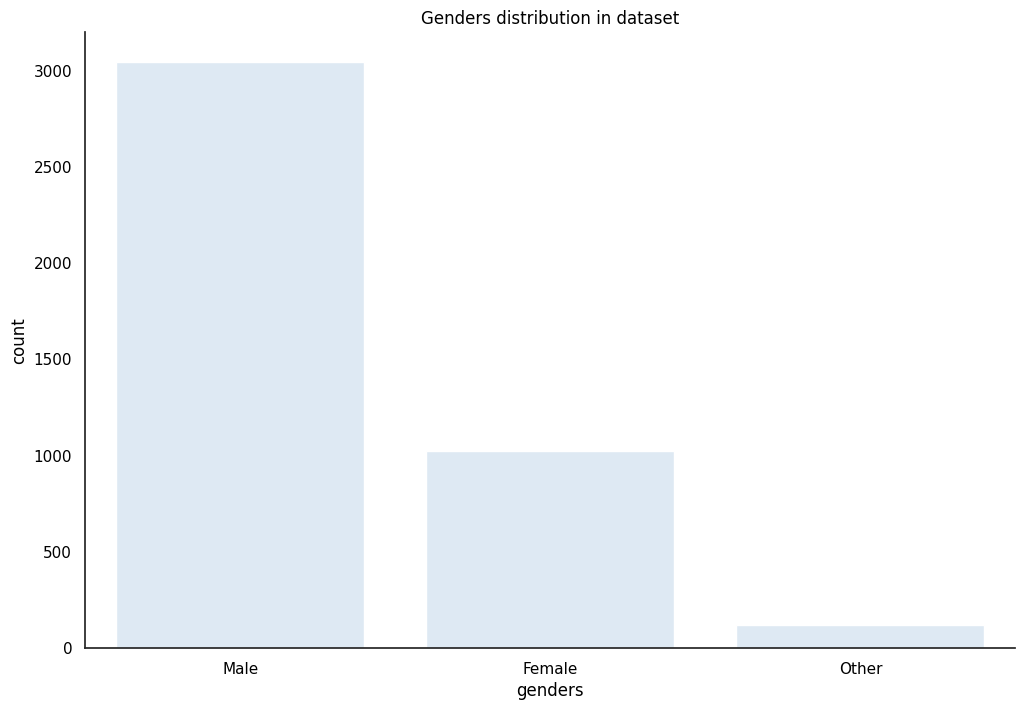

In [43]:
genders_df = pd.read_sql_query(
    """
    SELECT q.questionid, q.questiontext,
        CASE
            WHEN a.AnswerText IN ("Male", "male", "Male-ish", "MALE", "I have a penis") THEN "Male"
            WHEN a.AnswerText IN ("Female", "female", "Female-ish") THEN "Female"
            ELSE "Other"
        END as genders,
        COUNT(a.AnswerText) as count
    FROM Question q
        LEFT JOIN Answer a ON a.QuestionID == q.questionid
    WHERE q.questionid == 2 AND a.AnswerText != "-1"
    GROUP BY genders
    ORDER BY count DESC""",
    conn,
)
plt.figure(figsize=(12, 8))
sns.barplot(genders_df, x="genders", y="count")
sns.despine()
plt.title("Genders distribution in dataset")

In [44]:
genders_by_year_df = pd.read_sql_query(
    """
    SELECT q.questionid, q.questiontext,
    CASE
        WHEN a.AnswerText IN ("Male", "male", "Male-ish", "MALE", "I have a penis") THEN "Male"
        WHEN a.AnswerText IN ("Female", "female", "Female-ish") THEN "Female"
        ELSE "Other"
    END as genders,
    COUNT(a.AnswerText) as count,
    a.SurveyID
    FROM Question q
            LEFT JOIN Answer a ON a.QuestionID == q.questionid
    WHERE q.questionid == 2 AND a.AnswerText != "-1"
    GROUP BY a.SurveyID, genders
    ORDER BY a.SurveyID, count
    """,
    conn,
)

In [118]:
genders_without_other_df = genders_by_year_df[genders_by_year_df["genders"] != "Other"]

genders_without_other_df.loc[:, "count"] = np.where(
    genders_without_other_df["genders"] == "Male",
    genders_without_other_df.loc[:, "count"],
    -genders_without_other_df.loc[:, "count"],
)

From graph below we can see how over the years bias towards gender proportion has been becoming smaller.

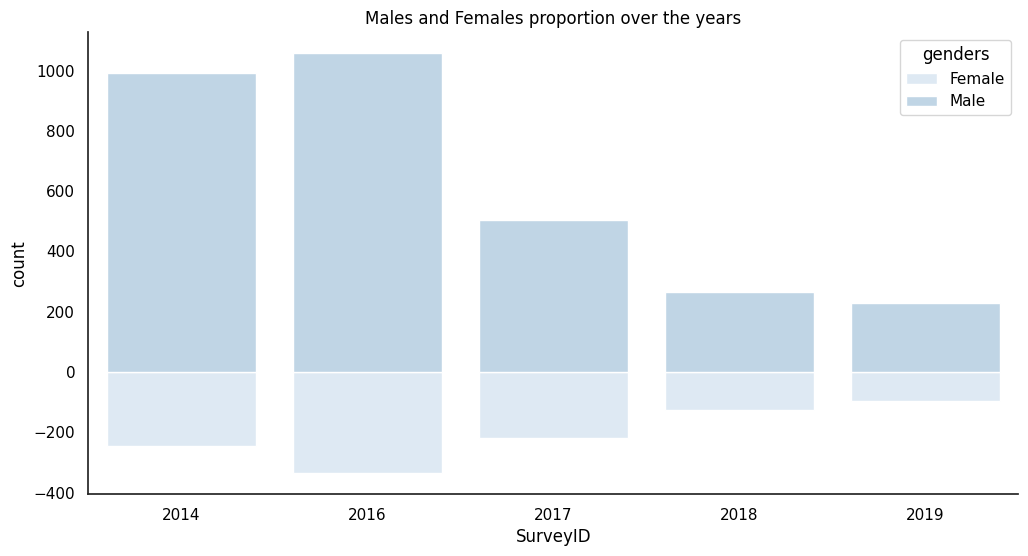

In [117]:
plt.figure(figsize=(12, 6))
sns.barplot(data=genders_without_other_df, x="SurveyID", y="count", hue="genders", dodge=False)
plt.title("Males and Females proportion over the years")
sns.despine()

From the graph below notice how most respondents are from USA. Following with 5 times less respondents from UK. This shows that this survey represents mostly mental health in USA tech workplaces.

Text(0.5, 1.0, '10 most frequent countries in survey')

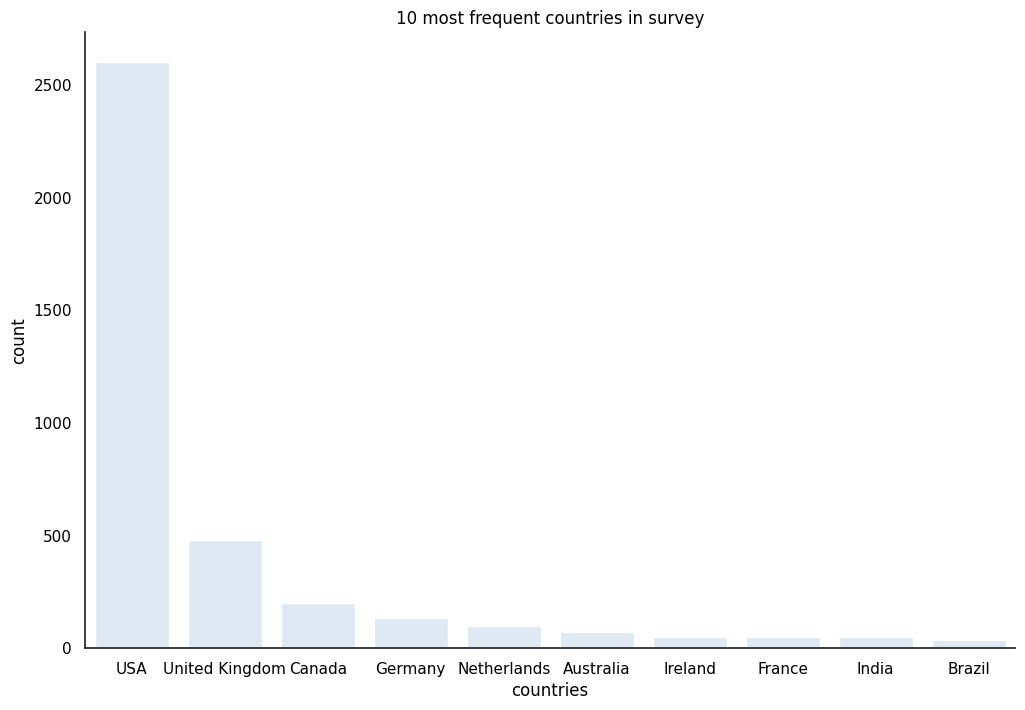

In [49]:
countries_df = pd.read_sql_query(
    """
    SELECT q.questionid, q.questiontext,
        CASE
            WHEN a.AnswerText IN ("United States of America", "United States") THEN "USA"
            ELSE a.AnswerText
        END as countries,
        COUNT(a.AnswerText) as count
    FROM Question q
        LEFT JOIN Answer a ON a.QuestionID == q.questionid
    WHERE q.questionid == 3 AND countries != "-1"
    GROUP BY countries
    ORDER BY count DESC""",
    conn,
)
plt.figure(figsize=(12, 8))
sns.barplot(countries_df.head(10), x="countries", y="count")
sns.despine()
plt.title("10 most frequent countries in survey")

In [50]:
countries_df.head()

,questionid,questiontext,countries,count
0,3,What country do you live in?,USA,2604
1,3,What country do you live in?,United Kingdom,482
2,3,What country do you live in?,Canada,199
3,3,What country do you live in?,Germany,136
4,3,What country do you live in?,Netherlands,98


Here I do a bit of processing to compare how many respondents living in USA an other countries. I do that by summing up respondents from other countries.

In [51]:
new_row = {
    "questionid": 3,
    "questiontext": "What country do you live in",
    "countries": "other",
    "count": countries_df[countries_df["countries"] != "USA"]["count"].sum(),
}
usa_df = countries_df[countries_df["countries"] == "USA"]
usa_df.loc[1] = new_row

/tmp/ipykernel_242094/3939474922.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_df.loc[1] = new_row


Below notice that there are more respondents from USA than all other countries combined.

In [52]:
usa_df.head()

,questionid,questiontext,countries,count
0,3,What country do you live in?,USA,2604
1,3,What country do you live in,other,1612


As you can see from below there is quite even distribution between people working (343) and not working (333) remotely. While people who work sometimes remotely is double of either class (757).

In [53]:
remote_df = pd.read_sql_query(
    """
    SELECT q.questionid, q.questiontext, a.AnswerText, COUNT(a.AnswerText)  as count, a.SurveyID
    FROM Question q
        LEFT JOIN Answer a ON a.QuestionID == q.questionid
    WHERE q.questionid == 118
    GROUP BY a.SurveyID, a.AnswerText""",
    conn,
)
remote_df

,questionid,questiontext,AnswerText,count,SurveyID
0,118,Do you work remotely?,Always,343,2016
1,118,Do you work remotely?,Never,333,2016
2,118,Do you work remotely?,Sometimes,757,2016


Below is graph to illustrate this knowledge. Notice how this question is asked only in 2016 survey.

Text(0.5, 1.0, 'Distribution of people working remotely in 2016 survey')

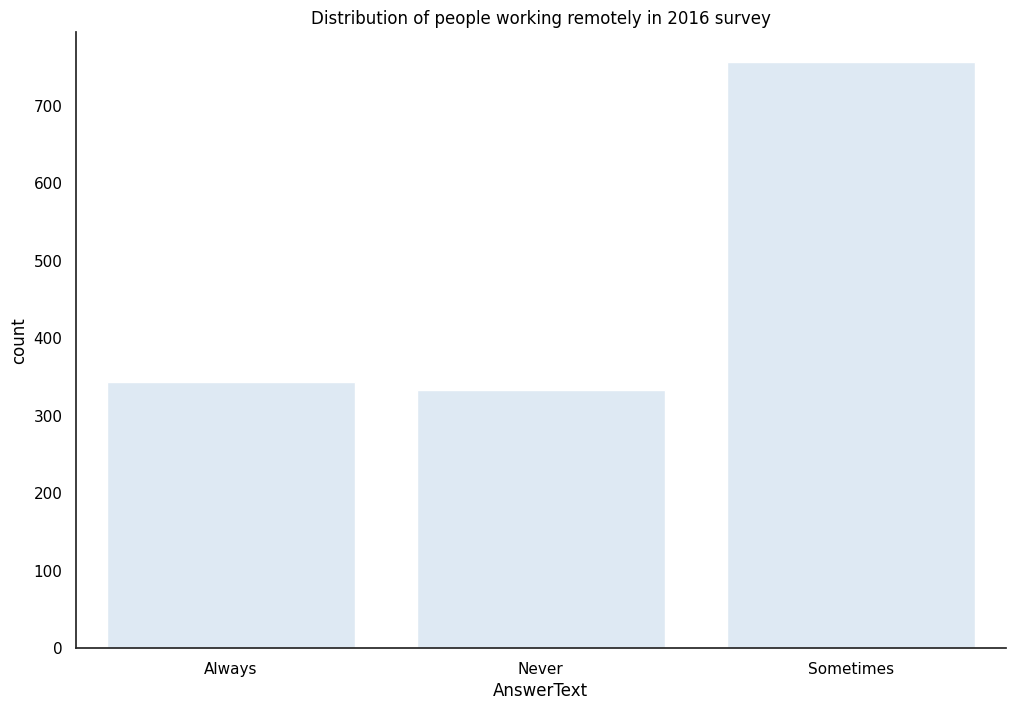

In [54]:
plt.figure(figsize=(12, 8))
sns.barplot(remote_df, x="AnswerText", y="count")
sns.despine()
plt.title("Distribution of people working remotely in 2016 survey")

Below graph illusatrates how proportions of unanaswered questions increase over the years.

/tmp/ipykernel_242094/1318762385.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  response_counts.groupby(["questiontext", "SurveyID"]).apply(calculate_counts).reset_index()


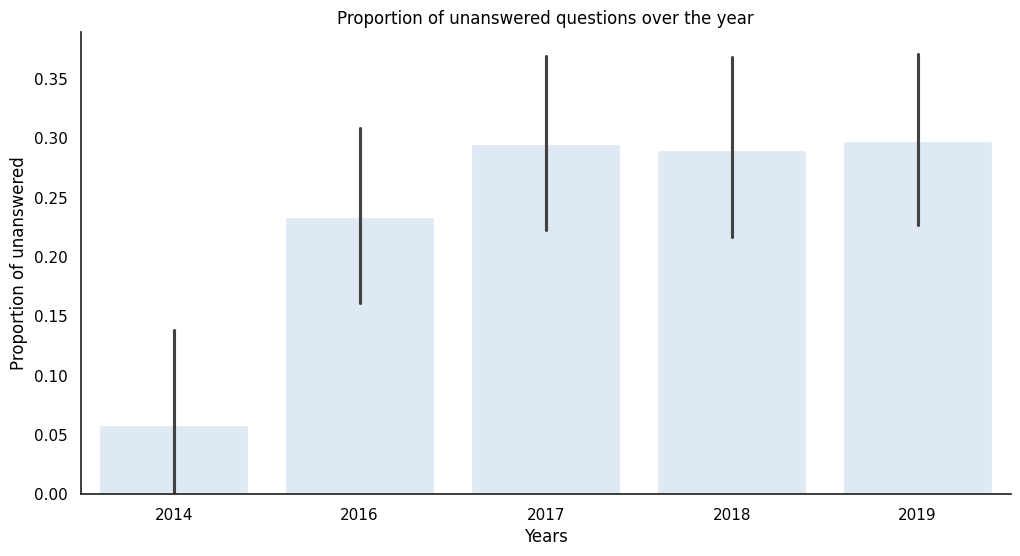

In [112]:
response_counts = (
    raw_df.groupby(["questiontext", "AnswerText", "SurveyID"]).size().reset_index(name="count")
)
result_df = (
    response_counts.groupby(["questiontext", "SurveyID"]).apply(calculate_counts).reset_index()
)
plt.figure(figsize=(12, 6))
sns.barplot(result_df, x="SurveyID", y="null_proportion")
sns.despine()
plt.title("Proportion of unanswered questions over the year")
plt.ylabel("Proportion of unanswered")
plt.xlabel("Years")
plt.show()

# Data Preprocessing

Before exploring data I will preprocess data to make it more suitable for analysis. Notice the data is huge with a lot of questions asked, so I will be focusing on specific questions that are most relevant to the analysis goals. During the process of analysis I had to remove some questions as they were not relevant to the analysis goals, some others were not analysed due the shortage of time and resources.

Notice that I will preprocess data with pandas. This could be done with SQL queries as in previous section by creating a temporary table and then in each analysis section draw specific data from it. After first review I understood that would be a better approach as this section in programme is about SQL queries. But as I have already done the processing in pandas and shortage of time I decide to leave this as is, hoping several queries beforehand showcases my ability with SQL.

Another important thing to say is that -1 differs from Null values. In surveys -1 usually means the user did have the opportunity but did not answer, while null values means we just did not take this information. So -1 denotes some information, in which we will be looking into at the end of this section.

This is summary of processing done:

- Check for duplicates and null values.
- Choose questions that I want to analyze, and remove other questions.
- Remove users who are not tech workers as our target population is tech workers.
- Remove null values, in our case null values are in AnswerText column as "-1".
- Filter out "Not applicable to me" responses for the specific question.
- Save processed data to csv file to avoid processing data every time I run the notebook.

In [55]:
check_for_null_and_duplicates(raw_df)

2025-04-14 08:50:53,777 - INFO - Any Null values: False
2025-04-14 08:50:53,815 - INFO - Any -1 answers: True
2025-04-14 08:50:53,817 - INFO - Any duplicate columns: False
2025-04-14 08:50:54,025 - INFO - Any duplicate rows: False


### Choosing the questions to analyze

I want to analyze specific questions which can be found below.

In [56]:
questions = [
    "Have you had a mental health disorder in the past?",
    "Do you currently have a mental health disorder?",
    "Have you ever been diagnosed with a mental health disorder?",
    "If yes, what condition(s) have you been diagnosed with?",
    "If maybe, what condition(s) do you believe you have?",
    (
        "Overall, how well do you think the tech industry supports "
        "employees with mental health issues?"
    ),
    "Do you know the options for mental health care your employer provides?",
    ("Has your employer ever discussed mental health as part of an employee wellness program?"),
    (
        "Does your employer provide resources to learn more about mental health "
        "issues and how to seek help?"
    ),
    "Do you know local or online resources to seek help for a mental health issue?",
    "Would you be willing to discuss a mental health issue with your coworkers?",
    ("Would you be willing to discuss a mental health issue with your direct supervisor(s)?"),
    ("Would you bring up a mental health issue with a potential employer in an interview?"),
    "Have you ever discussed your mental health with coworkers?",
    "Have you ever discussed your mental health with your employer?",
    (
        "Do you feel that being identified as a person with a mental health issue "
        "would hurt your career?"
    ),
    (
        "If you have revealed a mental health issue to a client or business contact, "
        "do you believe this has impacted you negatively?"
    ),
    (
        "If you have revealed a mental health issue to a coworker or employee, "
        "do you believe this has impacted you negatively?"
    ),
    (
        "Have you observed or experienced an unsupportive or badly handled response "
        "to a mental health issue in your current or previous workplace?"
    ),
    (
        "Have you observed or experienced supportive or well handled response to a "
        "mental health issue in your current or previous workplace?"
    ),
]

Here I will be removing questions that are not relevant to the analysis goals.

In [57]:
processed_df = raw_df.reset_index(drop=False)
processed_df = processed_df[processed_df["questiontext"].isin(questions)]

### Filter out non-tech workers

In [58]:
users_to_exclude = processed_df[
    (processed_df["questiontext"] == questions[0]) & (processed_df["AnswerText"] == "0")
]["UserID"]

processed_df = processed_df[~processed_df["UserID"].isin(users_to_exclude)]

### Null values in AnswerText

I want to check null values situation in questions. Here I notice that there is some questions that have quite a lot of null values. Like "Do you know local or online resources to seek help for a mental health issue?" has 82% of null values. While question "have you ever been diagnosed with mental health disorder?" has 29% of null values. This is important to be aware of as it can affect the analysis.

While questions "if yes, what condition(s) have you been diagnosed with?" and "If maybe, what condition(s) do you believe you have?" have 42% and 62% of null values respectively. This is fine as these questions are follow up questions to the question "Do you currently have a mental health disorder?". 

Other questions have less than 15% of null values. Which is fine for this analysis.

In [59]:
analyze_null_values(processed_df)

,questiontext,null_count,other_count,total_count,null_proportion
14,If you have revealed a mental health issue to ...,1289,144,1433,0.899512
2,Do you know local or online resources to seek ...,2454,504,2958,0.829615
15,If you have revealed a mental health issue to ...,1146,287,1433,0.799721
12,"If maybe, what condition(s) do you believe you...",1111,682,1793,0.619632
13,"If yes, what condition(s) have you been diagno...",865,1207,2072,0.417471
6,Have you ever been diagnosed with a mental hea...,863,2095,2958,0.291751
7,Have you ever discussed your mental health wit...,221,1304,1525,0.144918
8,Have you ever discussed your mental health wit...,217,1308,1525,0.142295
10,Have you observed or experienced an unsupporti...,91,2867,2958,0.030764
9,Have you had a mental health disorder in the p...,15,2943,2958,0.005071


Now I will be removing all null values in AnswerText column.

In [60]:
answers_to_exclude = processed_df[(processed_df["AnswerText"] == "-1")]["index"]
processed_df = processed_df[~processed_df["index"].isin(answers_to_exclude)]

Filter out "Not applicable to me" responses for the specific question

In [61]:
mask = (processed_df["questiontext"] == questions[2]) & (
    processed_df["AnswerText"] != "Not applicable to me"
)
processed_df = processed_df[mask | (processed_df["questiontext"] != questions[2])]

## Save processed data

In [62]:
processed_df.to_csv("data/processed_mental_health.csv", index=False)

# Exploratory Analysis

Now with preprocessing done I will focus on exploring data and analysing it to draw conclusions. This section is divided into 5 distinct subsections:

- Firstly, we will look into what part of target population has or had mental health disorder to asses the importance of the situation.
- Secondly, we will look into overall support for mental health in tech industry to find whether there is a need for improvement.
- Thirdly, we will look into most prevelant disorders so companies could focus on them in mental health awareness campaigns.
- Fourthly, we will asses whether emplyoees have knowledge of resources available whether by company or online.
- Fifthly, we will look into how open people are about mental health issues and whether they are willing to discuss it with colleagues or supervisors.

Let me set the theme for graphs below and lets move into analysis

## What part of target population has mental health disorder?

In this section I will look at what part of target population has mental health disorder. In the dataset I have found the following questions related to mental health disorders:

In [29]:
questions_mental_health_disorder = [
    "Have you had a mental health disorder in the past?",
    "Do you currently have a mental health disorder?",
    "Have you ever been diagnosed with a mental health disorder?",
    "If yes, what condition(s) have you been diagnosed with?",
    "If maybe, what condition(s) do you believe you have?",
]

Notice how in the graph below there is 50% of people who had mental health disorder or has mental disorder currently. This is a huge number of people who are affected by mental health disorders.

Also notice how data is biased after 2016 survey. In years 2017, 2018 and 2019 almost all people who answered these questions are or have been diagnosed with mental health disorder. While in 2016 there were 50% of people who answered these questions are not diagnosed with mental health disorder.

This might come from the way data was collected. Maybe in 2016 data was collected in workplaces and in later years it was collected online. This might cause some bias in data. 

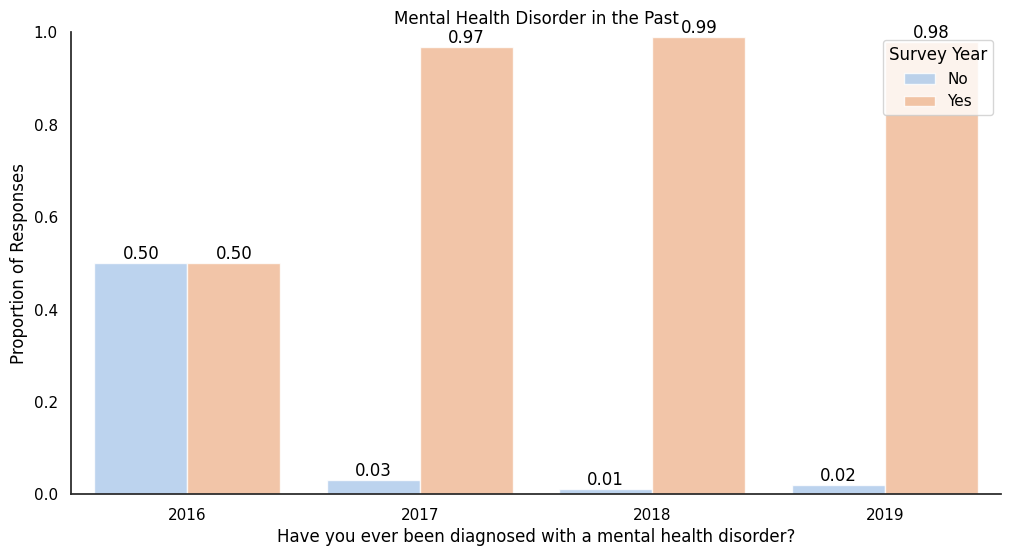

In [30]:
plot_question_grouped_by_years(
    processed_df, questions_mental_health_disorder[2], "Mental Health Disorder in the Past"
)

It is important to note that question above has 29% percent of null values. But if you take a look at the graph below which analyses a similar question "Do you currently have mental health disorder?". Notice how in 2016 there was 40% who said yes they have mental health disorder while to previous question there was 50% who said they have had or have mental health disorder. THis is similar amount and notice that question below has another option maybe with 23% of which some might have disorder or some people might have answered no, as they are healed from the disorder adding up to 50% in previous question. So in this case the high proportion of null values seems not to distort the analysis.

But notice how in years after 2016 people around 30% of respondents answered no to the question "Do you currently have a mental health disorder?" while in those years in every year over 97% of respondents answered yes to the question "Have you ever been diagnosed with a mental health disorder?". This shows that at least 27% of respondents had disorder and healed from it. 

Thus by providing support this could help not only help people with disorders but also help people who have healed from it to stay healthy. Further more, by providing support we can help people who are diagnosed with disorder to heal from it. All this amounts to a healthier workplace and happier employees.

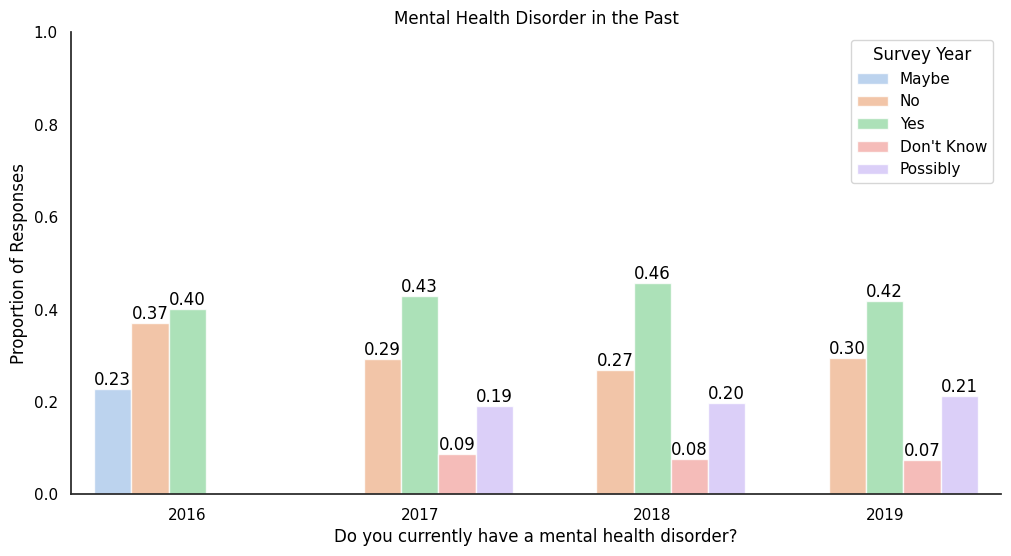

In [31]:
plot_question_grouped_by_years(
    processed_df, questions_mental_health_disorder[1], "Mental Health Disorder in the Past"
)

## Overall support for mental health

Okey from previous section we see that there is a quite a lot of people with mental health disorders. Let us look into how well the tech industry supports employees with mental health issues overall

In [32]:
question = [
    "Overall, how well do you think the tech industry supports "
    "employees with mental health issues?"
]

Notice how only 14% of respondents have rated tech industry support for mental health issues as good or excellent. This shows that there is a lot of room for improvement in tech industry support for mental health issues. While there is small trend that more people are rating it as good or excellent over the years and less as poor and average.

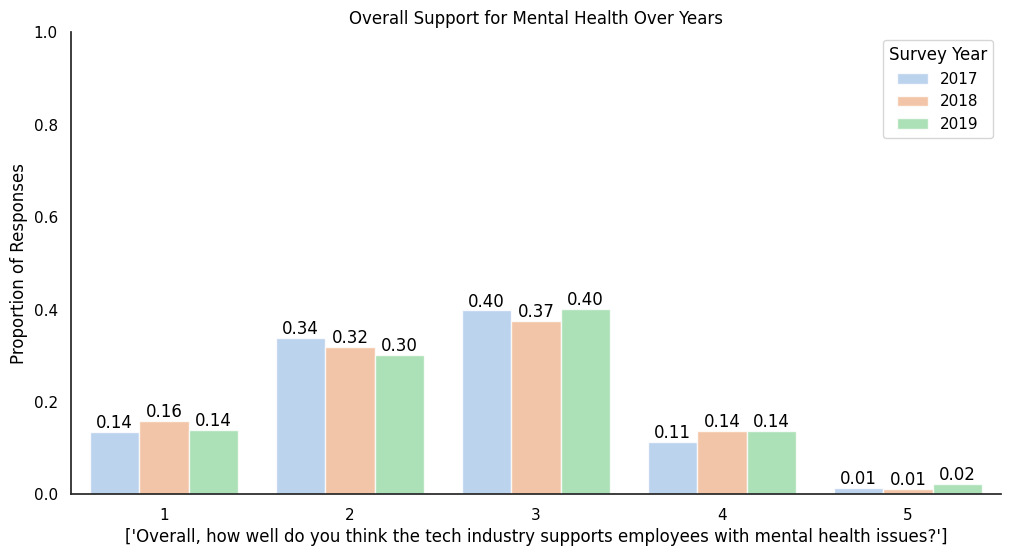

In [33]:
plot_question_grouped_by_answers(
    processed_df, question, "Overall Support for Mental Health Over Years"
)

## Prevelance rate of disorders and its confidence interval

I have seen that there is a quite a lot of people with mental health disorders and that there is a lot of room for improvement in tech industry support for mental health issues. I will look into prevelance rate of disorders and its confidence interval to find out the most common disorders to be able to target them in mental health awareness campaigns.

### Process to find data to calculate prevelance rate of disorders

This is the process I went through to find data to calculate prevelance rate. This can be skipped if you want to go directly to insights drawn from prevelance rate and its confidence interval.

Now I want to calculate prevalence rate and its confidence interval for mental health disorders. Distribution of people with health disorders can be gathered from the following questions:

In [34]:
questions_mental_health_disorder[3:5]

['If yes, what condition(s) have you been diagnosed with?',
 'If maybe, what condition(s) do you believe you have?']

I assume these 2 questions are related to each other due to its nature of question. But notice how we dont know to what these answers are related to. We need to know total number of people who answered previous question to calculate prevelance rate. The following are the candidates for previous question:

In [35]:
questions_mental_health_disorder[0:3]

['Have you had a mental health disorder in the past?',
 'Do you currently have a mental health disorder?',
 'Have you ever been diagnosed with a mental health disorder?']

I checked the how data was collected and the question "Do you currently have a mental health disorder?" is followed by "If yes, what condition(s) have you been diagnosed with?" and then "If maybe, what condition(s) do you believe you have?". Now knowing this collection we can calculate prevelance rate. Also I will calculate prevelance rate for only diagnosed people to make it dependable. But notice this will drop prevelance rate.

 Notice how our chosen question "if yes, what condition(s) have you been diagnosed with?" has been asked only in 2016 Survey. while previous question we decided on "Do you currently have a mental health disorder?" has been asked in all surveys except 2014. I have double checked that In original dataset there is extra questions in 2017, 2018 and 2019 year like "If so, what disorder(s) were you diagnosed with?" which could be used to complement our data. But for some reason Kaggle dataset has not scraped these questions. (Or my query must be messing up, but I double checked and I have the same amount of responses and unique questions as in Kaggle, so it seems to be working perfectly.)

 For this reason we will be only working with 2016 year survey data on mental health disorders diagnosis.

In [36]:
processed_df[
    processed_df["questiontext"].isin(
        [questions_mental_health_disorder[1], questions_mental_health_disorder[3]]
    )
].groupby(["questiontext", "SurveyID"]).size()

questiontext                                             SurveyID
Do you currently have a mental health disorder?          2016        1433
                                                         2017         756
                                                         2018         417
                                                         2019         352
If yes, what condition(s) have you been diagnosed with?  2016        1207
dtype: int64

In [37]:
processed_df[
    (processed_df["questiontext"] == questions_mental_health_disorder[1])
    & (processed_df["AnswerText"] == "Yes")
].groupby(["AnswerText", "SurveyID"]).size()

AnswerText  SurveyID
Yes         2016        575
            2017        324
            2018        191
            2019        147
dtype: int64

Notice how there are only 575 responses which said yes we currently have mental disorder diagnosis while 1207 said what kind of diagnosis we have. This brings me to question the reliability of this question. I have an idea that question "if yes, what condition(s) have you been diagnosed with?" in 2016 has been changed into "If so, what disorder(s) were you diagnosed with?" in later years. If thats the case this should have the same question_id. Lets investigate

In [38]:
raw_df[raw_df["questiontext"] == "If yes, what condition(s) have you been diagnosed with?"][
    "questionid"
].iloc[0]

np.int64(115)

In [39]:
raw_df[
    raw_df["questiontext"] == "If yes, what condition(s) have you been diagnosed with?"
].count().iloc[0]

np.int64(2072)

In [40]:
raw_df[raw_df["questionid"] == 115].count().iloc[0]  # noqa: PLR2004

np.int64(2072)

My usage of text instead of question id seems not to be a problem. Maybe "Do you currently have a mental health disorder?" answers with yes over the years adds up to a similar amount? Then this would make sense: This question has been only summed instead of divided into years.

In [41]:
for year in range(2016, 2020):
    print(year)  # noqa: T201
    print(  # noqa: T201
        processed_df[
            (processed_df["questiontext"] == questions_mental_health_disorder[1])
            & (processed_df["SurveyID"] == year)
            & (processed_df["AnswerText"] == "Yes")
        ]
        .groupby("AnswerText")
        .size()
    )

2016
AnswerText
Yes    575
dtype: int64
2017
AnswerText
Yes    324
dtype: int64
2018
AnswerText
Yes    191
dtype: int64
2019
AnswerText
Yes    147
dtype: int64


This adds up to 1237 which is close to 1207. I have an idea that the question has been summed over the years instead of being divided into years.
Now I want to check some of the users who answered to "If yes, what condition(s) have you been diagnosed with?" but not to "Do you currently have a mental health disorder?" While searching for this I found that there is only 568 unique users who answered to follow up question. Which is exactly what I am looking for.

In [42]:
len(
    processed_df[
        processed_df["questiontext"] == "If yes, what condition(s) have you been diagnosed with?"
    ]["UserID"].unique()
)

568

In [43]:
users_with_main_answer = processed_df[
    (processed_df["questiontext"] == "Do you currently have a mental health disorder?")
    & (processed_df["SurveyID"] == 2016)  # noqa: PLR2004
    & (processed_df["AnswerText"] == "Yes")
]["UserID"].unique()
len(users_with_main_answer)

575

As there is over double non-unique responses I want to check what are some answers that are not unique

In [44]:
non_unique_answers = (
    processed_df[
        processed_df["questiontext"] == "If yes, what condition(s) have you been diagnosed with?"
    ]["UserID"]
    .value_counts()
    .reset_index()
)
non_unique_answers.head(5)

,UserID,count
0,2625,9
1,1435,8
2,2441,8
3,1892,7
4,2368,7


After further investigation into most answers given User 2625 I found that they claim to have 9 different disorders diagnosed. This explains all non-unique answers doubling that of unique users.

In [45]:
processed_df[
    (processed_df["questiontext"] == "If yes, what condition(s) have you been diagnosed with?")
    & (processed_df["UserID"] == 2625)  # noqa: PLR2004
][["UserID", "AnswerText", "SurveyID"]]

,UserID,AnswerText,SurveyID
116792,2625,"Anxiety Disorder (Generalized, Social, Phobia,...",2016
116793,2625,"Mood Disorder (Depression, Bipolar Disorder, etc)",2016
116794,2625,"Eating Disorder (Anorexia, Bulimia, etc)",2016
116795,2625,Attention Deficit Hyperactivity Disorder,2016
116796,2625,Obsessive-Compulsive Disorder,2016
116797,2625,Post-traumatic Stress Disorder,2016
116798,2625,Stress Response Syndromes,2016
116799,2625,Dissociative Disorder,2016
116800,2625,Addictive Disorder,2016


Let's sort disorders by number of responses to find most common disorders

In [46]:
processed_df[
    processed_df["questiontext"] == "If yes, what condition(s) have you been diagnosed with?"
].groupby(["questiontext", "AnswerText"]).size().reset_index(name="counts").sort_values(
    ["questiontext", "counts"], ascending=False
).head(5)

,questiontext,AnswerText,counts
17,"If yes, what condition(s) have you been diagno...","Mood Disorder (Depression, Bipolar Disorder, etc)",412
2,"If yes, what condition(s) have you been diagno...","Anxiety Disorder (Generalized, Social, Phobia,...",345
4,"If yes, what condition(s) have you been diagno...",Attention Deficit Hyperactivity Disorder,121
23,"If yes, what condition(s) have you been diagno...",Post-traumatic Stress Disorder,69
18,"If yes, what condition(s) have you been diagno...",Obsessive-Compulsive Disorder,45


### Prevalence Rate Calculation

Let's calculate the prevalence rate for mental health disorders using the 2016 survey data, which includes follow-up questions about specific conditions. Notice I will be using question "Do you currently have a mental health disorder?" which does not have any -1 values.

#### Key Components:

1. **Population Size**: 1,433 respondents from 2016 survey
2. **Diagnosed Cases**: 575 respondents answered "Yes" to "Do you currently have a mental health disorder?"
4. **Total Condition Reports**: 1,207 responses (some respondents reported multiple conditions)

#### Prevalence Rate Formula:
$\text{Prevalence Rate} = \text{Diagnosis Rate} \times \text{Condition Rate}$

I think I need to stratify this
Where:
- **Diagnosis Rate** = Diagnosed Cases / Population = 575/1433
- **Condition Rate** = Number of specific condition reports / Total condition reports

In [30]:
mood_prevelance_rate = calculate_disorder_prevalence(
    processed_df, "Mood Disorder (Depression, Bipolar Disorder, etc)"
)

NameError: name 'processed_df' is not defined

### Confidence Interval using bootstrap

Now as I have calculated prevelance rate I want to calculate confidence interval for it. For this I will use bootstrap method which is a non-parametric method that resamples the data with replacement to estimate the distribution of the statistic. In our case we will be resampling the data to estimate the distribution of the prevelance rate.

As can be seen from information below confidence interval of Mood disorderprevelence rate is from 0.12 to 0.15. This means that we can be 95% confident that if we resampled once more then prevelance rate of mood disorder in tech industry would be between 0.12 and 0.15. This shows that more than 12% of tech workers have mood disorder with 95% confidence level. While similarly Anxiety disorder has over 10% and ADHD has over 4% of tech workers.

In [48]:
results_mood = analyze_disorder_prevalence(
    df=processed_df,
    disorder_name="Mood Disorder (Depression, Bipolar Disorder, etc)",
    n_iterations=1000,
    confidence_level=0.95,
)

2025-04-07 09:13:27,210 - INFO - Original Prevalence Rate: 0.14
2025-04-07 09:13:27,213 - INFO - 95% Confidence Interval: (0.12, 0.15)
2025-04-07 09:13:27,214 - INFO - Standard Error: 0.01


In [49]:
results_anxiety = analyze_disorder_prevalence(
    df=processed_df,
    disorder_name="Anxiety Disorder (Generalized, Social, Phobia, etc)",
    n_iterations=1000,
    confidence_level=0.95,
)

2025-04-07 09:13:37,630 - INFO - Original Prevalence Rate: 0.11
2025-04-07 09:13:37,631 - INFO - 95% Confidence Interval: (0.10, 0.13)
2025-04-07 09:13:37,632 - INFO - Standard Error: 0.01


In [50]:
results_adhd = analyze_disorder_prevalence(
    df=processed_df,
    disorder_name="Attention Deficit Hyperactivity Disorder",
    n_iterations=1000,
    confidence_level=0.95,
)

2025-04-07 09:13:46,384 - INFO - Original Prevalence Rate: 0.04
2025-04-07 09:13:46,385 - INFO - 95% Confidence Interval: (0.03, 0.05)
2025-04-07 09:13:46,386 - INFO - Standard Error: 0.00


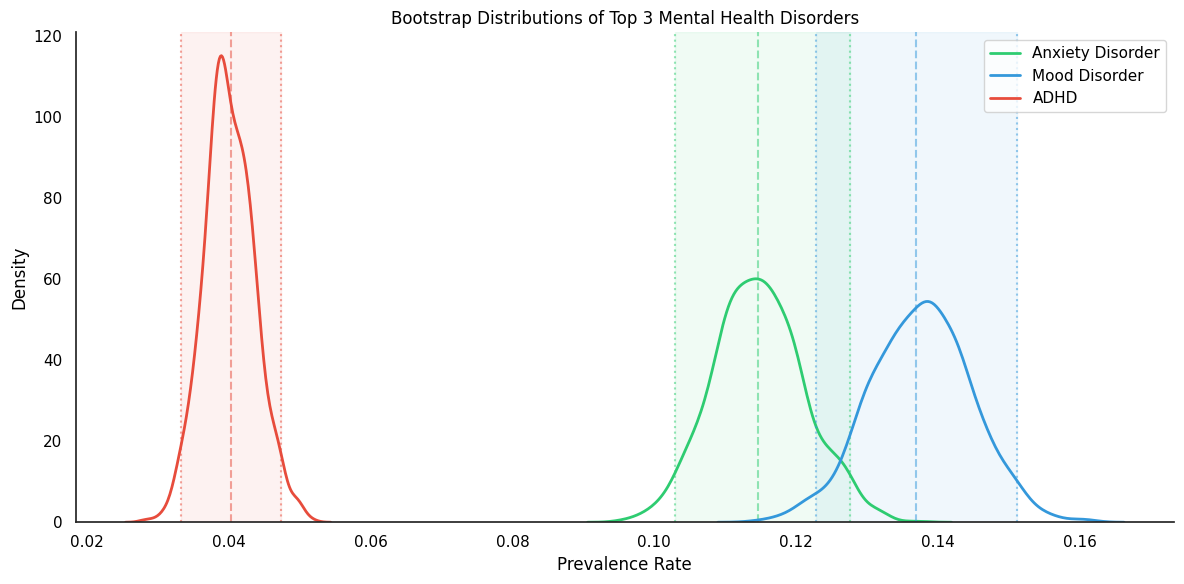

In [51]:
disorders = {"anxiety": results_anxiety, "mood": results_mood, "adhd": results_adhd}
disorder_names = ["Anxiety Disorder", "Mood Disorder", "ADHD"]
plot_multiple_disorders_distribution(disorders, disorder_names)

From this I conclude that that there is quite a lot of people with disorders in tech industry. Thus it is important to know about them and foster openess and support for people with disorders. To do that we need to know what are the most common disorders as to focus on them. With this information we can create targeted campaigns to introduce Mood Disorder, Anxiety Disorder and ADHD to colleagues. This way people can be more aware of these disorders and know how to support people with them making workplace more supportive and inclusive.

## Knowledge of support:

It is important to know whether people know about other resources already available to them. In this section I will look in to this.

In [52]:
questions = [
    "Do you know the options for mental health care your employer provides?",
    "Has your employer ever discussed mental health as part of an employee wellness program?",
    (
        "Does your employer provide resources to learn more about mental "
        "health issues and how to seek help?"
    ),
    "Do you know local or online resources to seek help for a mental health issue?",
]

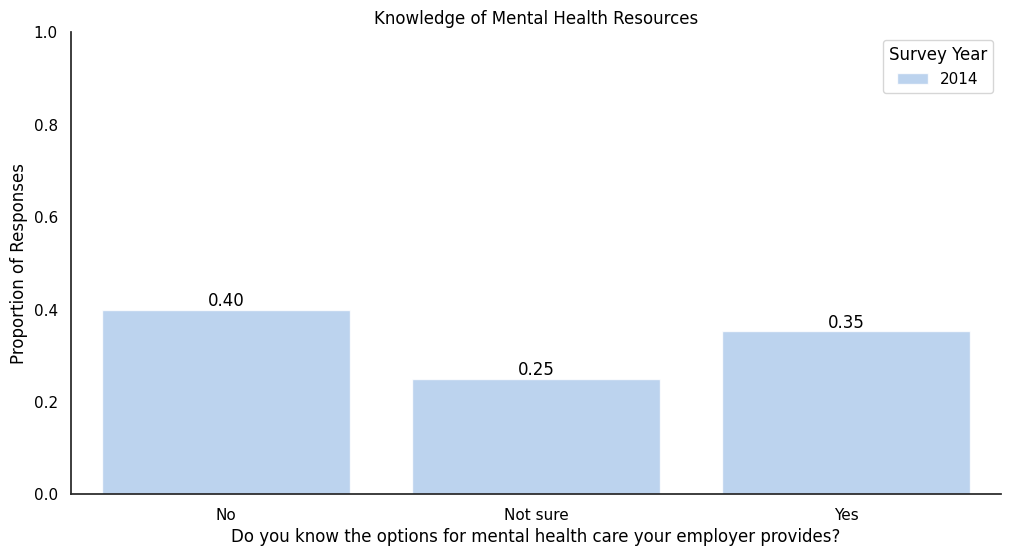

In [53]:
plot_question_grouped_by_answers(
    processed_df, questions[0], "Knowledge of Mental Health Resources"
)

From graph above 65% does not know or is not sure about resources already available to them. Which is a good indicator for area of improvement.

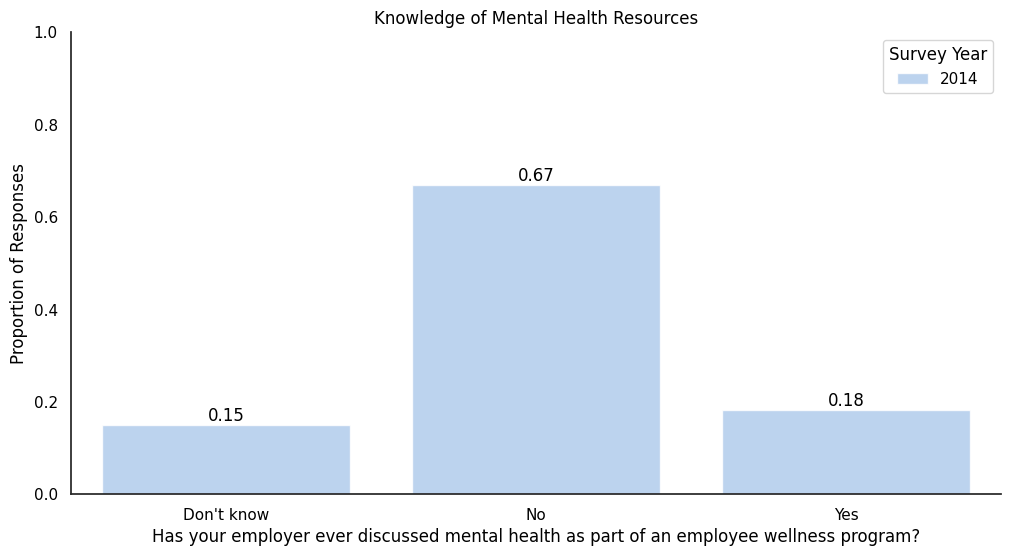

In [54]:
plot_question_grouped_by_answers(
    processed_df, questions[1], "Knowledge of Mental Health Resources"
)

Part of the reason why people do not know about resources is that employers do not discuss mental health as part of an employee wellness program as can be seen from the graph above as 85% of respondents says employers did not discuss it or are not sure.

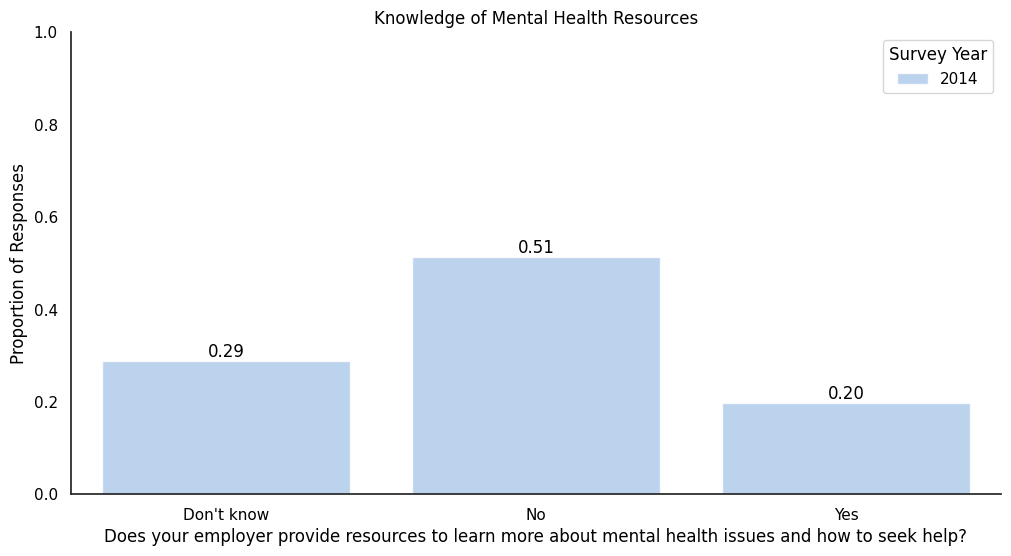

In [55]:
plot_question_grouped_by_answers(
    processed_df, questions[2], "Knowledge of Mental Health Resources"
)

Some employers does not provide resources as 54% of respondents says employer did not provide resources.

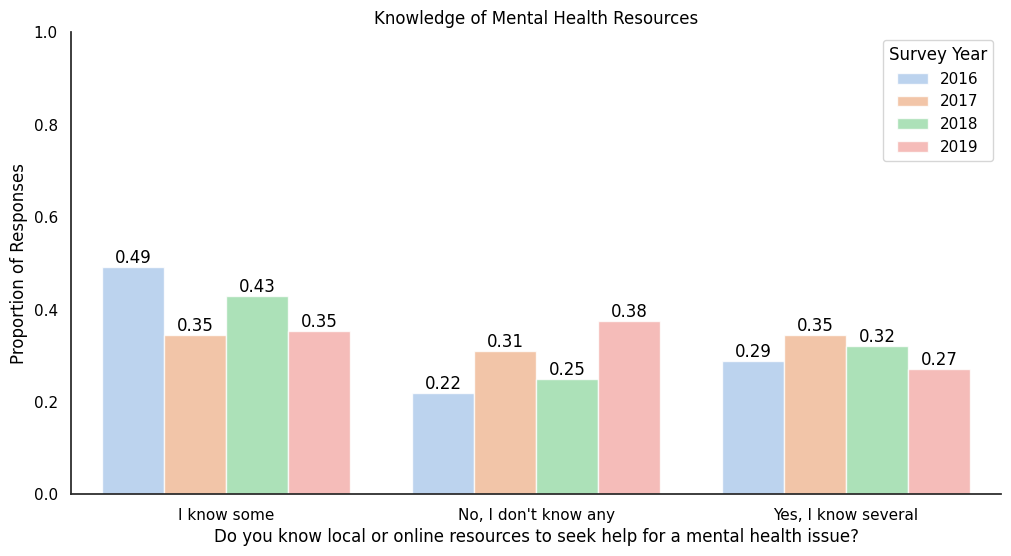

In [56]:
plot_question_grouped_by_answers(
    processed_df, questions[3], "Knowledge of Mental Health Resources"
)

Over the years proportion of respondents who do not know any resources has been increasing and almost doubled from 22% in 2016 to 38% in 2019 as can be seen from the graph above. 

Overall in mental health awareness campaign it is important to focus on raising awareness about resources available to employees whether it be local or online resources. 

## Openness:

To be able to help people with mental health disorders we need to know how open they are about it. In this section I will look at how open people are about mental health. I will be investigating following questions:

In [57]:
questions = [
    "Would you be willing to discuss a mental health issue with your coworkers?",
    "Would you be willing to discuss a mental health issue with your direct supervisor(s)?",
    "Would you bring up a mental health issue with a potential employer in an interview?",
    "Have you ever discussed your mental health with coworkers?",
    "Have you ever discussed your mental health with your employer?",
]

From the graph below I can see that people are quite open about mental health with 80% of respondents saying they would be willing to discuss a mental health issue with some of their coworkers which is a good sign.

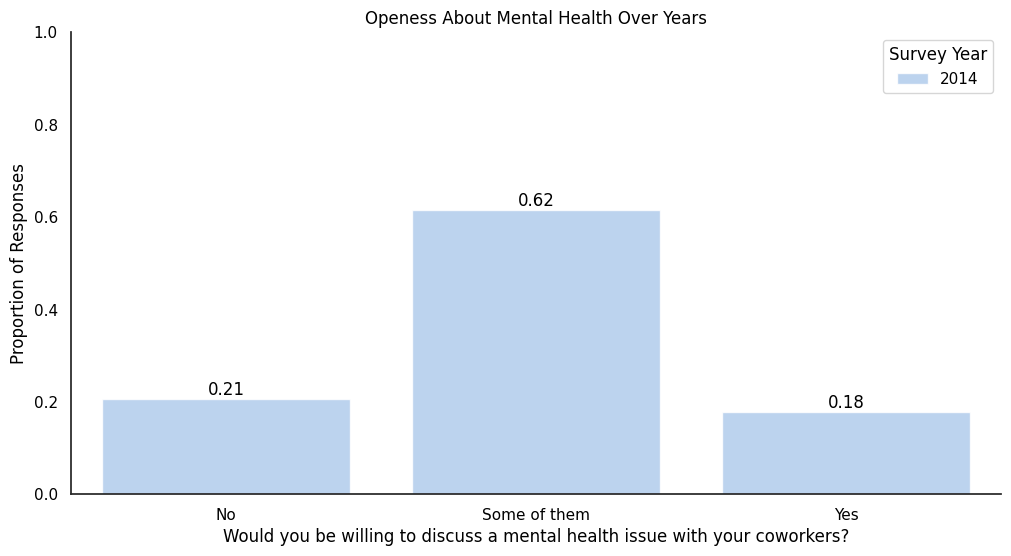

In [58]:
plot_question_grouped_by_answers(
    processed_df, questions[0], "Openess About Mental Health Over Years"
)

While from the graph below we can see that 70% of respondents would be willing to discuss a mental health issue with their direct supervisor(s). This shows that less people are willing to discuss a mental health issue with their direct supervisor(s) compared to coworkers overall.

It is important to note that willing to discuss with any coworkers is only 19% while with any supervisor it is 42%. Probably supervisors seems more dependable and trustworthy than some of the coworkers.

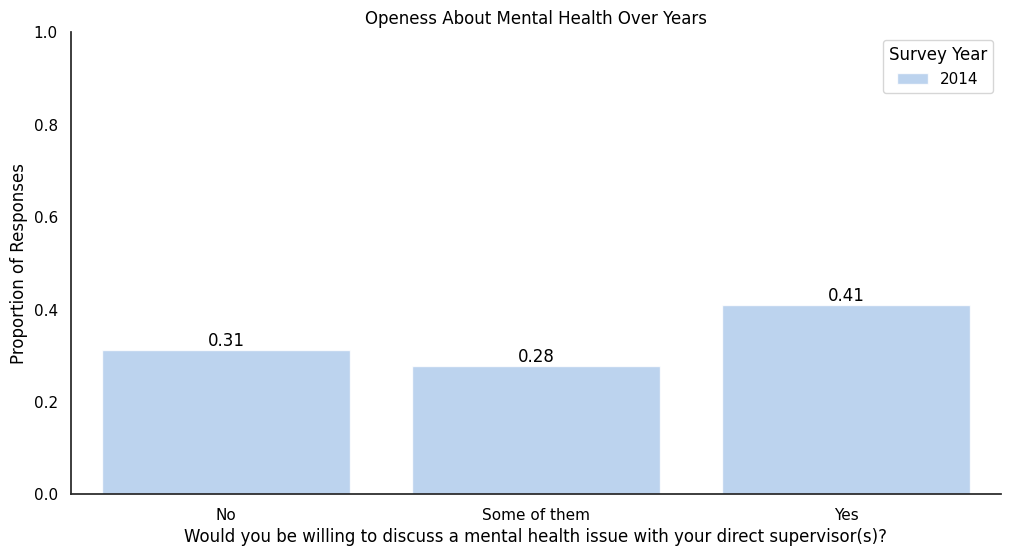

In [59]:
plot_question_grouped_by_answers(
    processed_df, questions[1], "Openess About Mental Health Over Years"
)

from the graph below notice how around 70% of respondents over the years would not bring up a mental health issue with a potential employer in an interview. This shows that people are not open about mental health issues in interviews.

But there is a trend that people are more open about mental health issues in interviews over the years. Proportionally respondents who would categorically say they would not bring up a mental health issue in an interview has decreased from 78% in 2014 to 63% in 2019. While people who might bring up a mental health issue in an interview has increased by 14% over the same period. This shows a trend that if conditions are right people would be more open about mental health issues in interviews.

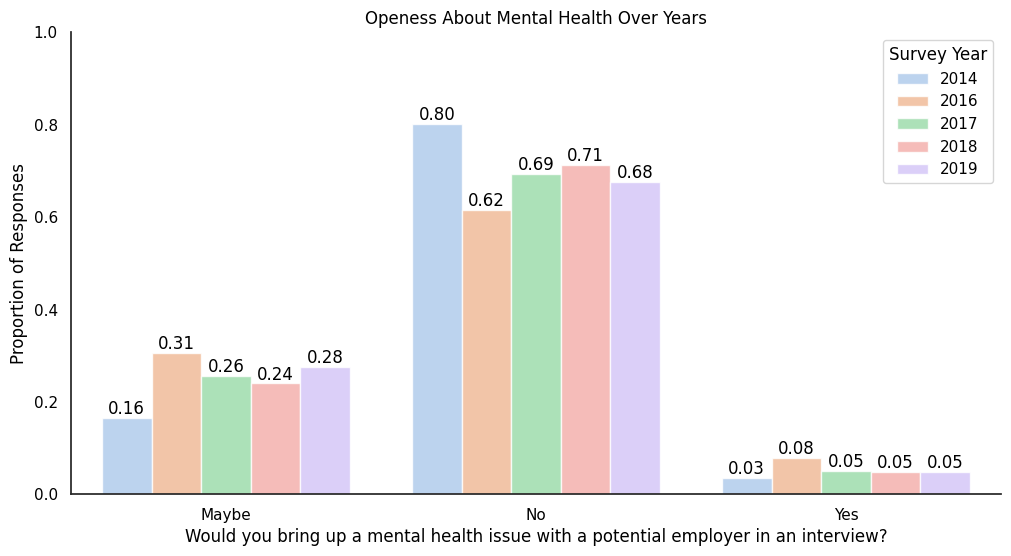

In [60]:
plot_question_grouped_by_answers(
    processed_df, questions[2], "Openess About Mental Health Over Years"
)

### Fear for career prospects

To be able to open people about mental health disorders we need to know why they are not open about it. We will be investigating following questions:

In [61]:
questions = [
    "Do you feel that being identified as a person with a mental health issue would hurt "
    "your career?",
    "If you have revealed a mental health issue to a client or business contact, do you believe "
    "this has impacted you negatively?",
    "If you have revealed a mental health issue to a coworker or employee, do you believe this "
    "has impacted you negatively?",
    "Have you observed or experienced an unsupportive or badly handled response to a mental "
    "health issue in your current or previous workplace?",
    "Have you observed or experienced supportive or well handled response to a mental health "
    "issue in your current or previous workplace?",
]

From the graph below we can see that hefty 39% of respondents feel that being identified as a person with a mental health issue would hurt their career. While for 7% it has affected their career in a negative way out compared to 2% who said it has not affected their career in negative way. This shows one of the reasons why people are afraid of being identified as a person with a mental health issue is because they feel their career will be affected in negative way. And this seems the case for most of the respondents who have been identified as a person with a mental health issue.

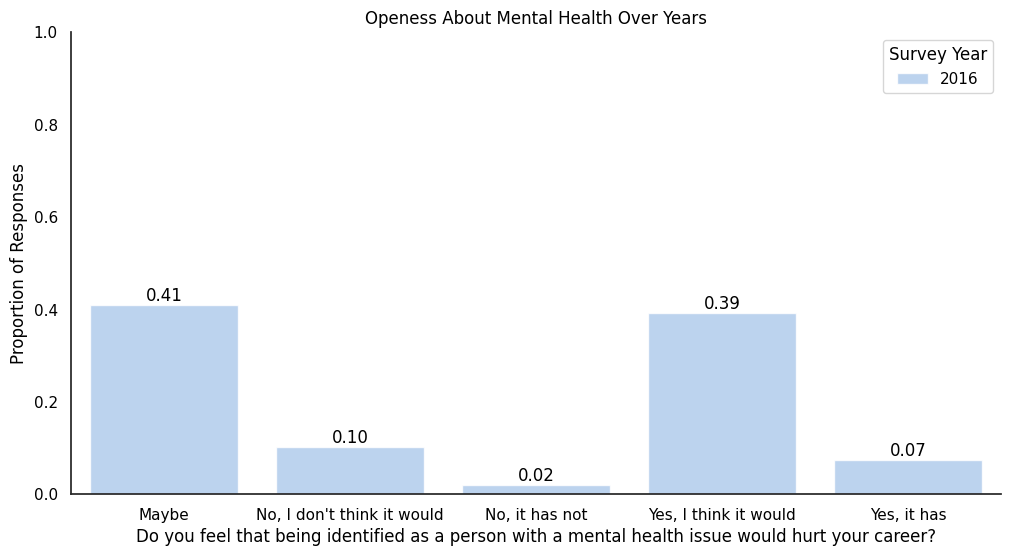

In [62]:
plot_question_grouped_by_answers(
    processed_df, questions[0], "Openess About Mental Health Over Years"
)

Revealing mental issue to a client/business contact has definetly impacted negatively with their connection with the client/business contact for 25% of respondents. While 29% of respondents said it has not impacted their connection with the client/business contact. Others are not sure.

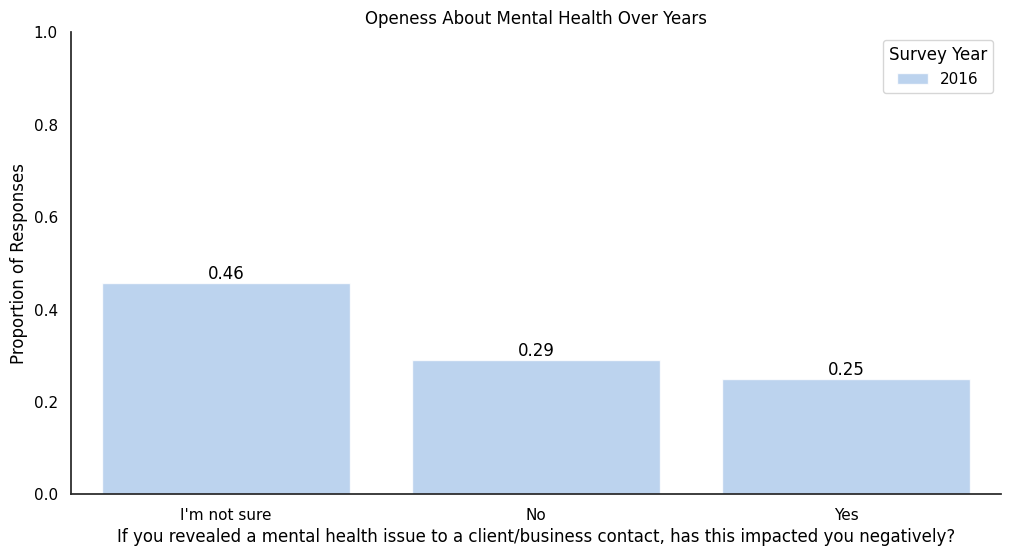

In [63]:
plot_question_grouped_by_answers(
    processed_df,
    questions[1],
    "Openess About Mental Health Over Years",
    "If you revealed a mental health issue to a client/business contact, "
    "has this impacted you negatively?",
)

From the graph below we can see that revealing mental issue to a coworker/employee has impacted their connection with the coworker/employee for 23% of respondents. While for 37% of respondents said it has not impacted their connection with the coworker/employee negatively. Others are not sure. 

This shows there is less of no negative impact on revealing mental issue to a coworker/employee compared to a client/business contact. This shows that people are more comfortable with revealing mental issue to a coworker/employee than a client/business contact which does make sense. While still showing that there is a negative impact on connection with the coworker/employee.

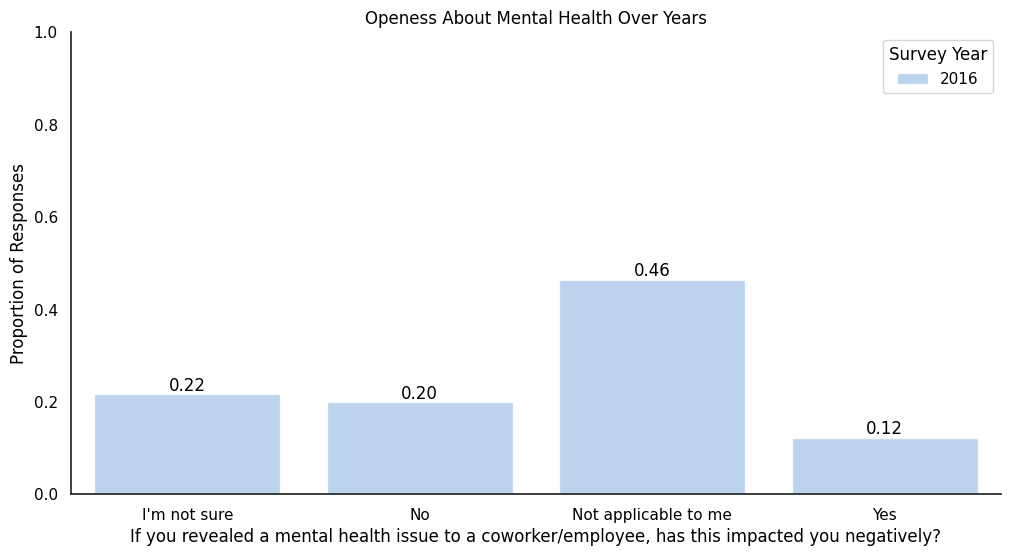

In [64]:
plot_question_grouped_by_answers(
    processed_df,
    questions[2],
    "Openess About Mental Health Over Years",
    "If you revealed a mental health issue to a coworker/employee, "
    "has this impacted you negatively?",
)

All in all, I would advise Focus on how to not have negative career impact, and how to assure that wont be the case, as that iso ne of the reasons why people are afraid of disclosing their mental health issues.

### Coworkers and supervisors responses

From two graphs below we can see that over the years on average 13% of respondents have experienced unsupportive response to a mental health issue in their current or previous workplace. While around 22% of respondents have experienced supportive response. Which is good news as more people have experienced supportive response than unsupportive response. But it is still a lot of people who have experienced unsupportive response.

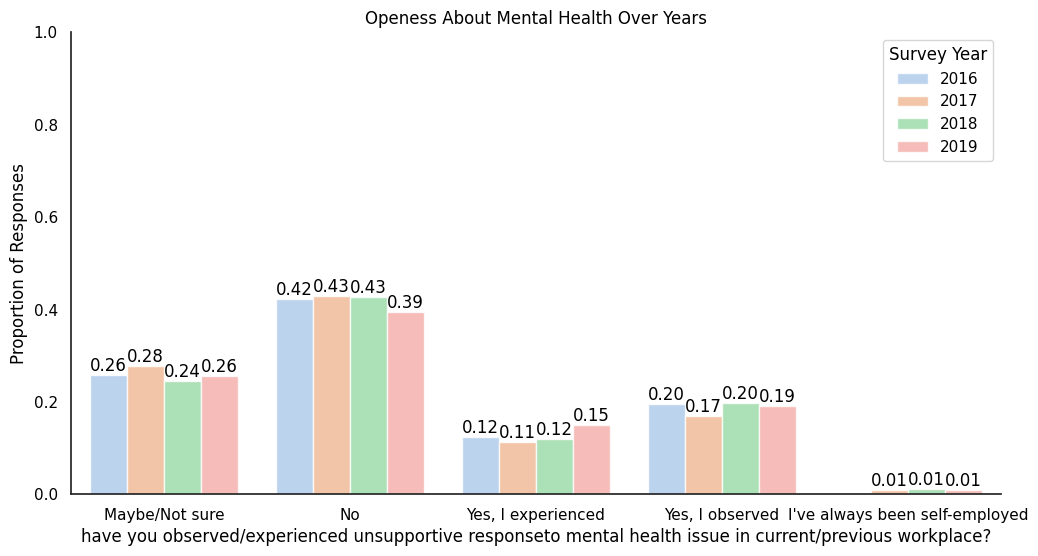

In [65]:
plot_question_grouped_by_answers(
    processed_df,
    questions[3],
    "Openess About Mental Health Over Years",
    "have you observed/experienced unsupportive responseto mental "
    "health issue in current/previous workplace?",
)

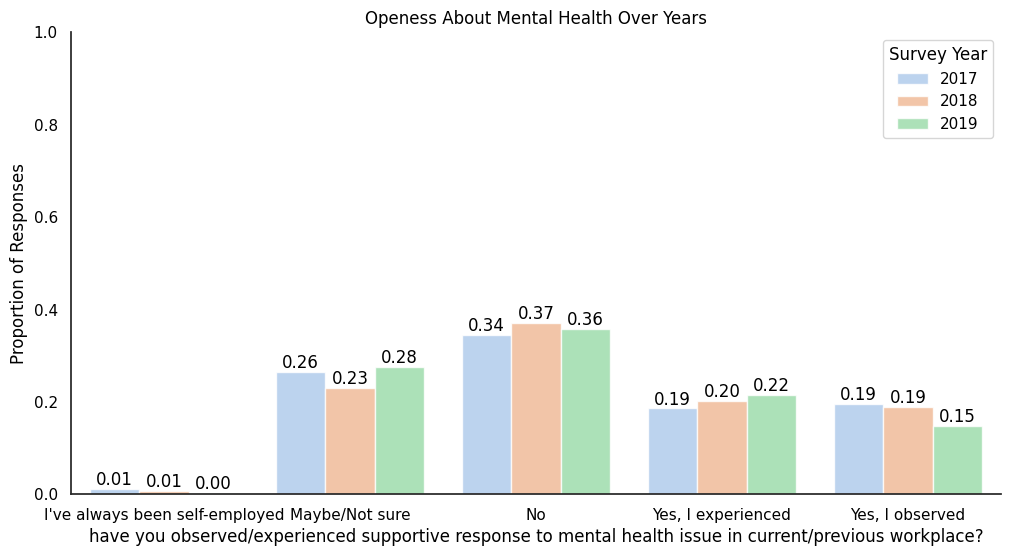

In [66]:
plot_question_grouped_by_answers(
    processed_df,
    questions[4],
    "Openess About Mental Health Over Years",
    "have you observed/experienced supportive response "
    "to mental health issue in current/previous workplace?",
)

All in all, I would advise on improving supportive responses to mental health issues as there is evidence of negative responses to mental health issues in workplace. 

### Introduction picture

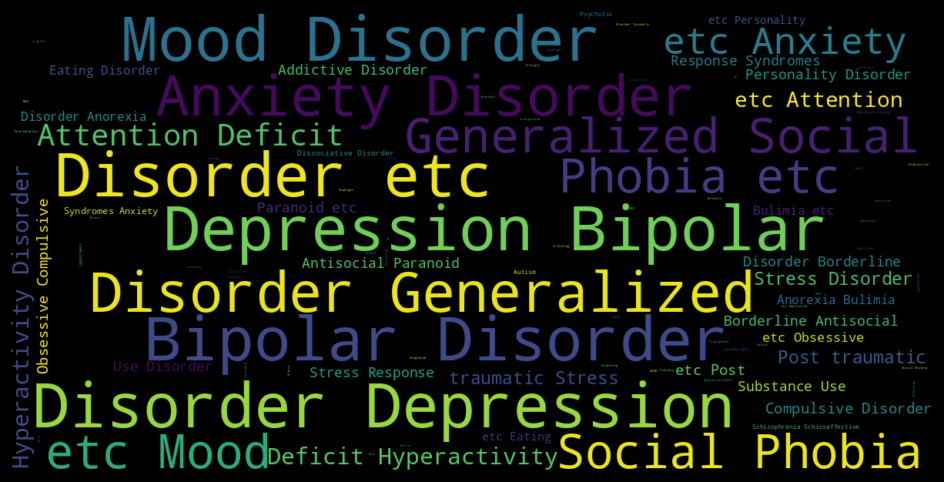

In [ ]:
text = " ".join(
    processed_df[
        processed_df["questiontext"] == "If yes, what condition(s) have you been diagnosed with?"
    ]["AnswerText"].astype(str)
)

wordcloud = WordCloud(width=1200, height=600, max_font_size=80).generate(text)
plt.figure(figsize=(12, 6), facecolor="k")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Conclusions

All in all mental issuses in tech industry are quite common with 50% of respondents having or had a mental health disorder diagnosis. While employees 14% have rated support in tech companies being excellent or good. This shows that it is important to be aware of mental health issues and there is lack for good support.

To improve mental health support for employees I advice:
- Make mental health awareness campaign about most prevelant disorders what they are and how to support people with them. Most prevelant are Mood Disorder between 12% and 15%, Anxiety Disorder between 10% and 13%, ADHD between 3% and 5% with 95% confidence level.
- Remind on available resources and help with mental health issues as 65% of target population does not know of or is not sure of any resources available in the company. One of the reasons why this is such a hight number might be that there is 67% of respondents saying companies haven't talked about mental health when considering employee wellness.
- People are generally willing to be open as 80% of target population has some coworkers and 70% has some supervisors to whom they are willing to open up. It is important to say to get people open up company has to have certain condition
- To have people open up about mental health issues policy should make it crystal clear that opening up  wont result in negative career impact as 39% of target population think openning up would hurt their career and for 7% more it has.
- Another way get people open up about mental health issues is to improve responses of coworkers/empyees as around 13% of population have experienced and around 19% have observed unsupportive response from coworkers/employees.
- There is evidence people are becoming more open about mental health issues in interviews as at the start of the survey in 2014 there were 80% categorically closed respondents while in 2019 there were 68%. So there is possibility to be open with one third of employees from the start.

# Improvements

My recommendations for further analysis to improve mental health support for employees:
- Investigate what precentage in survey there is open ended questions, multi-choice, yes/no, rating and etc
- Take a look into open ended questions
- Cut the data in parts to discuss different social-demographic groups.
- Take a look at data with adjusted weights along same years to treat data bias towards earlier years.
- Look at questions on specific policies which work and which dont, like mental health benefits, medical leave, anonymity protection, etc.
- Look at questions describing bad and supportive responses to learn what works and what doesnt.
- inclue latest years in analysis as well as latest data has been collected in 2019 and now there is data from every year up to 2024.